# Data Preperation

In [276]:
# Packages and enviroment required for the project
# conda create --name master-prj
# conda activate master-prj
# conda install pytorch::pytorch torchvision torchaudio -c pytorch
# conda install pandas scikit-learn matplotlib

In [277]:
import os
import pandas as pd
import numpy as np
import warnings
import random
from typing import Tuple
import torch
from torch.utils.data import Dataset, DataLoader # Import the Dataset class
import torch.nn as nn
import torch.optim as optim
import math
from sklearn.metrics import precision_score, recall_score, f1_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from typing import List, Tuple
import time
import seaborn as sns

random_seed_number = 42
warnings.filterwarnings("ignore")
# random.seed(random_seed_number)
np.random.seed(random_seed_number)
torch.manual_seed(random_seed_number)

device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)
!rm -r "sample_data"

cpu
rm: cannot remove 'sample_data': No such file or directory


In [278]:
user_file     = "user_info.csv"
landmark_file = "landmark_info.csv"
rating_file   = "rating_info.csv"

In [279]:
user_df = pd.read_csv(user_file, index_col="User_id").sort_index()

user_df["User_city"] = user_df["User_city"].str.lower()
user_df["User_province"] = user_df["User_province"].str.lower()

user_df["User_city"] = user_df["User_city"].astype("category")
user_df["User_province"] = user_df["User_province"].astype("category")

def categorical_age(age: int) ->str :
  if age < 20:
    return "Out-Of-Border"
  elif age < 40:
    return "Young"
  elif age < 60:
    return "Mid"
  elif age < 100:
    return "Old"
  else:
    return "Out-Of-Border"

user_df["User_age"] = user_df["User_age"].apply(categorical_age)
user_df["User_age"] = user_df["User_age"].str.lower()
user_df["User_age"] = user_df["User_age"].astype("category")
user_df.info()

print ("To make Sure all values are in range: Out-Of-Border is", "Out-Of-Border" in user_df["User_age"].values)

user_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 200 entries, 1 to 200
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   User_city      200 non-null    category
 1   User_province  200 non-null    category
 2   User_age       200 non-null    category
dtypes: category(3)
memory usage: 4.9 KB
To make Sure all values are in range: Out-Of-Border is False


,User_city,User_province,User_age
User_id,,,
1,tabriz,east azerbaijan,mid
2,amol,mazandaran,young
3,ahvaz,khuzestan,mid
4,karaj,alborz,young
5,shiraz,fars,young


In [280]:
landmark_df = pd.read_csv(landmark_file, index_col="Place_id").sort_index()

landmark_df["Place_name"] = landmark_df["Place_name"].str.lower()
landmark_df["Place_city"] = landmark_df["Place_city"].str.lower()
landmark_df["Place_province"] = landmark_df["Place_province"].str.lower()

landmark_df["Place_name"] = landmark_df["Place_name"].astype("category")
landmark_df["Place_city"] = landmark_df["Place_city"].astype("category")
landmark_df["Place_province"] = landmark_df["Place_province"].astype("category")

def categorical_price(price: int) ->str :
  if price < 0:
    return "Out-Of-Border"
  elif price == 0:
    return "Free"
  elif price <= 50000:
    return "Cheap"
  else:
    return "Expensive"

landmark_df["Place_price"] = landmark_df["Place_price"].apply(categorical_price)
landmark_df["Place_price"] = landmark_df["Place_price"].str.lower()
landmark_df["Place_price"] = landmark_df["Place_price"].astype("category")
landmark_df.info()

landmark_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 309 entries, 1 to 309
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Place_name      309 non-null    category
 1   Place_category  309 non-null    object  
 2   Place_city      309 non-null    category
 3   Place_province  309 non-null    category
 4   Place_price     309 non-null    category
dtypes: category(4), object(1)
memory usage: 23.3+ KB


,Place_name,Place_category,Place_city,Place_province,Place_price
Place_id,,,,,
1,meighan wetland,Natural,arak,markazi,free
2,four seasons bathhouse,Cultural,arak,markazi,cheap
3,arak bazaar,Cultural,arak,markazi,free
4,soltan abad (shazand) caravanserai,Historical,qazvin,qazvin,cheap
5,sepahdar school,Cultural,arak,markazi,cheap


In [281]:
rating_df = pd.read_csv(rating_file, index_col=["User_id", "Place_id"]).sort_index()
rating_df.head()


UserPlace_rating
User_id Place_id                  
1       18                       3
        52                       2
        61                       3
        79                       3
        89                       3

In [282]:
# prompt: how to select place_ids eual to 245
rating_df[rating_df.index.get_level_values(1)==2]
rating_df[rating_df.index.get_level_values(1)==246]
rating_df[rating_df.index.get_level_values(1)==224]
rating_df[rating_df.index.get_level_values(1)==159]

,,UserPlace_rating
User_id,Place_id,
17,159,1
139,159,1
145,159,4


In [283]:
merged_df = pd.merge(user_df, rating_df, left_index=True, right_index=True).sort_index()
merged_df = pd.merge(merged_df, landmark_df, left_index=True, right_index=True).sort_index()
dataset_df = merged_df[["User_city", "User_province", "User_age", "Place_name", "Place_category", "Place_city", "Place_province", "Place_price", "UserPlace_rating"]]
del merged_df
dataset_df.head()

User_city    User_province User_age           Place_name  \
User_id Place_id                                                            
1       18          tabriz  east azerbaijan      mid         moghan plain   
        52          tabriz  east azerbaijan      mid         vakil bazaar   
        61          tabriz  east azerbaijan      mid    margoon waterfall   
        79          tabriz  east azerbaijan      mid  ganjnameh waterfall   
        89          tabriz  east azerbaijan      mid        hengam island   

                 Place_category Place_city Place_province Place_price  \
User_id Place_id                                                        
1       18              Natural  bilasavar        ardabil        free   
        52             Cultural     shiraz           fars        free   
        61              Natural    sepidan           fars        free   
        79              Natural    hamedan        hamedan        free   
        89              Natural     hengam      hormuzgan       cheap   

                  UserPlace_rating  
User_id Place_id                    
1       18                       3  
        52                       2  
        61                       3  
        79                       3  
        89                       3

# Dataset Manipulation

In [284]:
dataset_df.head()

User_city    User_province User_age           Place_name  \
User_id Place_id                                                            
1       18          tabriz  east azerbaijan      mid         moghan plain   
        52          tabriz  east azerbaijan      mid         vakil bazaar   
        61          tabriz  east azerbaijan      mid    margoon waterfall   
        79          tabriz  east azerbaijan      mid  ganjnameh waterfall   
        89          tabriz  east azerbaijan      mid        hengam island   

                 Place_category Place_city Place_province Place_price  \
User_id Place_id                                                        
1       18              Natural  bilasavar        ardabil        free   
        52             Cultural     shiraz           fars        free   
        61              Natural    sepidan           fars        free   
        79              Natural    hamedan        hamedan        free   
        89              Natural     hengam      hormuzgan       cheap   

                  UserPlace_rating  
User_id Place_id                    
1       18                       3  
        52                       2  
        61                       3  
        79                       3  
        89                       3

In [285]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4176 entries, (1, 18) to (200, 308)
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   User_city         4176 non-null   category
 1   User_province     4176 non-null   category
 2   User_age          4176 non-null   category
 3   Place_name        4176 non-null   category
 4   Place_category    4176 non-null   object  
 5   Place_city        4176 non-null   category
 6   Place_province    4176 non-null   category
 7   Place_price       4176 non-null   category
 8   UserPlace_rating  4176 non-null   int64   
dtypes: category(7), int64(1), object(1)
memory usage: 145.9+ KB


In [286]:
age_dict = {
    "young": 0,
    "mid": 1,
    "old": 2
}

age_rev_dict = {
    0: "young",
    1: "mid",
    2: "old"
}

def age_to_number(age:str):
  return age_dict.get(age, -1)

def number_to_age(age:int):
  return age_rev_dict.get(age, "out-of-border")

In [287]:
price_dict = {
    "free": 0,
    "cheap": 1,
    "expensive": 2
}

price_rev_dict = {
    0: "free",
    1: "cheap",
    2: "expensive"
}

def price_to_number(price:str):
  return price_dict.get(price, -1)

def number_to_price(price:int):
  return price_rev_dict.get(price, "out-of-border")

In [288]:
place_category_dict = {
    "Natural": 0,
    "Cultural": 1,
    "Historical": 2,
    "Architectural": 3,
    "Amusement Park": 4
}

place_category_rev_dict = {
    0: "Natural",
    1: "Cultural",
    2: "Historical",
    3: "Architectural",
    4: "Amusement Park"
}

def place_category_to_number(place_category:str):
  return place_category_dict.get(place_category, -1)

def number_to_place_category(place_category:int):
  return place_category_rev_dict.get(place_category, "out-of-border")

In [289]:
city_list = dataset_df['Place_city'].sort_values().unique().tolist()

city_dict = {i: v for i, v in enumerate(city_list)}

city_rev_dict = {value: key for key, value in city_dict.items()}

def number_to_city(city:str):
  return city_dict.get(city, -1)

def city_to_number(city:int):
  return city_rev_dict.get(city, "out-of-border")

In [290]:
province_list = dataset_df['Place_province'].sort_values().unique().tolist()

province_dict = {i: v for i, v in enumerate(province_list)}

province_rev_dict = {value: key for key, value in province_dict.items()}

def number_to_province(province:str):
  return province_dict.get(province, -1)

def province_to_number(province:int):
  return province_rev_dict.get(province, f"{province}")

In [291]:
# prompt: create a dictionary between place id and place name and vice versa

place_id_to_name_dict = dict(zip(landmark_df.index, landmark_df['Place_name']))
place_name_to_id_dict = {v: k for k, v in place_id_to_name_dict.items()}

def place_id_to_name(place_id:int) -> str:
  return place_id_to_name_dict.get(place_id, "out-of-border")

def place_name_to_id(place_name:str) -> int:
  return place_name_to_id_dict.get(place_name, -1)


In [292]:
def min_max_normalize(ratings:int, r_min:int=1, r_max:int=5):
    normalized_ratings = (ratings - r_min) / (r_max - r_min)
    return normalized_ratings

def min_max_denormalize(normalized_ratings, r_min:int=1, r_max:int=5):
    denormalized_ratings = r_min + normalized_ratings * (r_max - r_min)
    return denormalized_ratings

def z_score_normalize(ratings, mean_rating, std_rating):
    normalized_ratings = (ratings - mean_rating) / std_rating
    return normalized_ratings

def z_score_denormalize(normalized_ratings, mean_rating, std_rating):
    denormalized_ratings = mean_rating + normalized_ratings * std_rating
    return denormalized_ratings

In [293]:
def transform_dataset(dataset: pd.DataFrame) -> pd.DataFrame:
  df = dataset.copy()
  df["User_age"]         = df["User_age"].apply(age_to_number)
  df["Place_price"]      = df["Place_price"].apply(price_to_number)
  df["Place_category"]   = df["Place_category"].apply(place_category_to_number)
  df["Place_city"]       = df["Place_city"].apply(city_to_number)
  df["Place_province"]   = df["Place_province"].apply(province_to_number)
  df["User_city"]        = df["User_city"].apply(city_to_number)
  df["User_province"]    = df["User_province"].apply(province_to_number)

  df["UserPlace_rating"] = df["UserPlace_rating"]-1
  std  = np.std(df["UserPlace_rating"])
  mean = np.mean(df["UserPlace_rating"])
  #df["UserPlace_rating"] = z_score_normalize(df["UserPlace_rating"].to_numpy(dtype=float), mean, std)

  df = df.drop(columns=["Place_name"])
  df = df.reset_index()
  df['User_id'] = df['User_id'] - 1
  df['Place_id'] = df['Place_id'] - 1
  df = df.set_index(['User_id', 'Place_id']).sort_index()
  return df

In [294]:
place_id_to_name(1)

'meighan wetland'

In [295]:
transform_dataset(dataset_df)

User_city User_province User_age  Place_category Place_city  \
User_id Place_id                                                               
0       17             101             4        1               0         14   
        51             101             4        1               1         96   
        60             101             4        1               0         90   
        78             101             4        1               0         35   
        88             101             4        1               0         36   
...                    ...           ...      ...             ...        ...   
199     214            116            30        1               1         65   
        231            116            30        1               0         87   
        251            116            30        1               0         15   
        270            116            30        1               4         47   
        307            116            30        1               0         30   

                 Place_province Place_price  UserPlace_rating  
User_id Place_id                                               
0       17                    1           0                 2  
        51                    5           0                 1  
        60                    5           0                 2  
        78                    8           0                 2  
        88                    9           1                 2  
...                         ...         ...               ...  
199     214                  14           0                 3  
        231                  21           0                 3  
        251                  15           0                 2  
        270                   0           2                 2  
        307                   7           0                 0  

[4176 rows x 8 columns]

In [296]:
def inverse_transform_dataset(dataset: pd.DataFrame, mean_arr: np.array=None, std_arr: np.array=None) -> pd.DataFrame:
  df = dataset.copy()
  df["User_age"] = df["User_age"].apply(number_to_age)
  df["Place_price"] = df["Place_price"].apply(number_to_price)
  df["Place_category"] = df["Place_category"].apply(number_to_place_category)
  df["Place_city"] = df["Place_city"].apply(number_to_city)
  df["Place_province"] = df["Place_province"].apply(number_to_province)
  df["User_city"] = df["User_city"].apply(number_to_city)
  df["User_province"] = df["User_province"].apply(number_to_province)
  df["Place_name"] = df.index.get_level_values('Place_id').map(place_id_to_name)

  if mean_arr is not None and std_arr is not None:
    df["UserPlace_rating"] = z_score_denormalize(df["UserPlace_rating"].to_numpy(dtype=float), mean_arr, std_arr) + 1
  else:
    df["UserPlace_rating"] = df["UserPlace_rating"] + 1

  df = df.reset_index()
  df['User_id'] = df['User_id'] + 1
  df['Place_id'] = df['Place_id'] + 1
  df = df.set_index(['User_id', 'Place_id']).sort_index()
  return df

In [297]:
std_arr = np.std(dataset_df["UserPlace_rating"]-1)
mean_arr = np.mean(dataset_df["UserPlace_rating"]-1)
inverse_transform_dataset(transform_dataset(dataset_df), mean_arr=None, std_arr=None)

User_city    User_province User_age  Place_category  \
User_id Place_id                                                       
1       18          tabriz  east azerbaijan      mid         Natural   
        52          tabriz  east azerbaijan      mid        Cultural   
        61          tabriz  east azerbaijan      mid         Natural   
        79          tabriz  east azerbaijan      mid         Natural   
        89          tabriz  east azerbaijan      mid         Natural   
...                    ...              ...      ...             ...   
200     215         zanjan           zanjan      mid        Cultural   
        232         zanjan           zanjan      mid         Natural   
        252         zanjan           zanjan      mid         Natural   
        271         zanjan           zanjan      mid  Amusement Park   
        308         zanjan           zanjan      mid         Natural   

                 Place_city   Place_province Place_price  UserPlace_rating  \
User_id Place_id                                                             
1       18        bilasavar          ardabil        free                 3   
        52           shiraz             fars        free                 2   
        61          sepidan             fars        free                 3   
        79          hamedan          hamedan        free                 3   
        89           hengam        hormuzgan       cheap                 3   
...                     ...              ...         ...               ...   
200     215         mashhad  khorasan razavi        free                 4   
        232            sari       mazandaran        free                 4   
        252         birjand   khorasan south        free                 3   
        271           karaj           alborz   expensive                 3   
        308           fuman           guilan        free                 1   

                                     Place_name  
User_id Place_id                                 
1       18        historical bridges of ardabil  
        52                        tomb of hafez  
        61                     afif-abad garden  
        79            esther and mordechai tomb  
        89                  bandar abbas bazaar  
...                                         ...  
200     215                         tebyan park  
        232                  garmsar salt mines  
        252                    makhunik village  
        271                      kordan village  
        308         gilan rural heritage museum  

[4176 rows x 9 columns]

# Model Implementation

In [298]:
# subset_df = dataset_df.groupby('Place_name').agg({'UserPlace_rating': ['mean', 'count'], 'Place_province': 'first'})
# subset_df.columns = ['Average Rating', 'Number of Ratings', 'Province']
# subset_df.sort_values('Average Rating', ascending=False)
# subset_df = subset_df[subset_df["Number of Ratings"] >= 20].sort_values('Number of Ratings', ascending=False).reset_index()
# dataset_df = dataset_df[dataset_df['Place_name'].isin(subset_df['Place_name'])]
# subset_df.head(50)
# dataset_df.info()

In [299]:
dataset = transform_dataset(dataset_df)
dataset.head(15)
CHECK0 = dataset[dataset["UserPlace_rating"].isna()]
CHECK1 = dataset[dataset["UserPlace_rating"]<0]
CHECK2 = dataset[dataset_df.index.get_level_values('Place_id')<1]
CHECK3 = dataset[dataset_df.index.get_level_values('Place_id')>=308]

In [300]:
def cross_val_split(dataset: pd.DataFrame,
                    n_splits: int,
                    random_seed_number: int) -> List[Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Perform K-fold cross-validation splitting on the dataset.

    Args:
    - dataset: The input dataset (DataFrame).
    - n_splits: The number of folds (K) for cross-validation.
    - random_seed_number: Random seed for reproducibility.

    Returns:
    - A list of tuples (train_df, test_df) for each fold.
    """
    # List to store the results of each fold
    fold_splits = []

    # Create a KFold object for cross-validation
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed_number)

    # Retrieve unique user IDs to split on
    user_ids = dataset.index.get_level_values(0).unique()

    # Iterate over each fold
    for train_indices, test_indices in kf.split(user_ids):
        train_users = user_ids[train_indices]
        test_users = user_ids[test_indices]

        # Split the dataset based on the current fold's train and test users
        train_data = []
        test_data = []

        for user_id in train_users:
            user_ratings = dataset.loc[user_id]
            place_ids = list(user_ratings.index)

            # Iterate over place IDs for the current user to build train data
            for place_id in place_ids:
                row = user_ratings.loc[place_id].to_list()
                row.insert(0, place_id)
                row.insert(0, user_id)
                train_data.append(row)

        for user_id in test_users:
            user_ratings = dataset.loc[user_id]
            place_ids = list(user_ratings.index)

            # Iterate over place IDs for the current user to build test data
            for place_id in place_ids:
                row = user_ratings.loc[place_id].to_list()
                row.insert(0, place_id)
                row.insert(0, user_id)
                test_data.append(row)

        # Recreate DataFrames from lists
        cols_names = dataset.index.names + dataset.columns.tolist()
        train_df = pd.DataFrame(train_data, columns=cols_names)
        test_df = pd.DataFrame(test_data, columns=cols_names)

        # Store the train and test DataFrames for the current fold
        fold_splits.append((train_df, test_df))

    return fold_splits

def train_test_split (dataset: pd.DataFrame,
                      ts_ratio:float=0.8
                      ) -> Tuple[pd.DataFrame, pd.DataFrame]:
  """
  Splits the dataset into training and testing sets.

  Args:
    dataset: The dataset to split.

  Returns:
    A tuple containing the training and testing sets.
  """
  cols_names = dataset.index.names + dataset.columns.tolist()
  #print(cols_names)
  train_data = []  # Initialize an empty list to store training data.
  test_data = []   # Initialize an empty list to store testing data.

  # Iterate over each unique user ID in the dataset.
  for user_id in dataset.index.get_level_values(0).unique():
    user_ratings = dataset.loc[user_id]  # Get all ratings for the current user.
    place_ids = list(user_ratings.index)  # Get the list of place IDs rated by the user.
    random.Random(random_seed_number).shuffle(place_ids)  # Shuffle the place IDs randomly (using a fixed seed for reproducibility).
    split_index = int(len(place_ids) * ts_ratio)   # Calculate the split index to divide the data into two halves.

    # Iterate over the first half of the shuffled place IDs to create training data.
    for place_id in place_ids[:split_index]:
      row = user_ratings.loc[place_id].to_list()  # Get the row of data for the current place ID.
      row.insert(0, place_id)  # Insert the place ID at the beginning of the row.
      row.insert(0, user_id)  # Insert the user ID at the beginning of the row.
      train_data.append(row)  # Add the row to the training data list.

    # Iterate over the second half of the shuffled place IDs to create testing data.
    for place_id in place_ids[split_index:]:
      row = user_ratings.loc[place_id].to_list()  # Get the row of data for the current place ID.
      row.insert(0, place_id)  # Insert the place ID at the beginning of the row.
      row.insert(0, user_id)  # Insert the user ID at the beginning of the row.
      test_data.append(row)  # Add the row to the testing data list.

  # Create DataFrames from the training and testing data lists.
  train_df = pd.DataFrame(train_data, columns=cols_names)
  test_df = pd.DataFrame(test_data, columns=cols_names)

  return train_df, test_df # Return the training and testing DataFrames.


In [301]:
class TouristDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        super().__init__()
        self.df = df.copy()

        self.user_id        = df['User_id'].values
        self.place_id       = df['Place_id'].values
        self.user_city      = df['User_city'].values
        self.place_city     = df['Place_city'].values
        self.user_province  = df['User_province'].values
        self.place_province = df['Place_province'].values
        self.user_age       = df['User_age'].values
        self.place_category = df['Place_category'].values
        self.place_price    = df['Place_price'].values
        self.targets        = df['UserPlace_rating'].values

    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
      return {
            'User_id':        self.user_id[idx],
            'Place_id':       self.place_id[idx],
            'User_city':      self.user_city[idx],
            'Place_city':     self.place_city[idx],
            'User_province':  self.user_province[idx],
            'Place_province': self.place_province[idx],
            'User_age':       self.user_age[idx],
            'Place_category': self.place_category[idx],
            'Place_price':    self.place_price[idx],
        }, self.targets[idx]

In [302]:
class MF_model(nn.Module):
    """ Matrix factorization model simple """
    def __init__(self, config: dict):
        super().__init__()
        self.user_id_emb  = nn.Embedding(config["n_user_id"],  config["emb_dim_user_id"])
        self.place_id_emb = nn.Embedding(config["n_place_id"], config["emb_dim_place_id"])
        self.device = config["device"]

    def forward(self, x):
        # Type Conversion
        user_id  = x['User_id']  if isinstance(x['User_id'],  torch.Tensor) else torch.tensor([x['User_id']],  dtype=torch.long).to(self.device)
        place_id = x['Place_id'] if isinstance(x['Place_id'], torch.Tensor) else torch.tensor([x['Place_id']], dtype=torch.long).to(self.device)
        # Calculate Embedding
        user_id_embd  = self.user_id_emb(user_id)
        place_id_embd = self.place_id_emb(place_id)
        # Predict Score
        element_product = (user_id_embd * place_id_embd).sum(1)
        return element_product

class MMF_model(nn.Module):
    """ Matrix factorization + user & place bias, weight init., sigmoid_range """
    def __init__(self, config: dict):
        super().__init__()
        self.user_id_emb  = nn.Embedding(config["n_user_id"],  config["emb_dim_user_id"])
        self.place_id_emb = nn.Embedding(config["n_place_id"], config["emb_dim_place_id"])

        self.user_id_bias  = nn.Parameter(torch.zeros(config["n_user_id"]))
        self.place_id_bias = nn.Parameter(torch.zeros(config["n_place_id"]))
        self.total_bias    = nn.Parameter(torch.zeros(1))
        self.device = config["device"]
        #self.user_id_emb.weight.data.uniform_(0., 0.05)
        #self.place_id_emb.weight.data.uniform_(0., 0.05)

    def forward(self, x):
        user_id  = x['User_id']  if isinstance(x['User_id'],  torch.Tensor) else torch.tensor([x['User_id']],  dtype=torch.long).to(self.device)
        place_id = x['Place_id'] if isinstance(x['Place_id'], torch.Tensor) else torch.tensor([x['Place_id']], dtype=torch.long).to(self.device)

        user_id_embd  = self.user_id_emb(user_id)
        place_id_embd = self.place_id_emb(place_id)

        element_product = (user_id_embd*place_id_embd).sum(1) + self.user_id_bias[user_id] + self.place_id_bias[place_id] + self.total_bias
        return torch.sigmoid(element_product) * (4.0 - 0.0) + 0.0


class FM_model(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        # Embeddings
        self.user_id_emb        = nn.Embedding(config["n_user_id"],  config["emb_dim_user_id"])
        self.place_id_emb       = nn.Embedding(config["n_place_id"], config["emb_dim_place_id"])
        self.user_city_emb      = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.place_city_emb     = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.user_province_emb  = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.place_province_emb = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.user_age_emb       = nn.Embedding(config["n_age"],      config["emb_dim_age"])
        self.place_category_emb = nn.Embedding(config["n_category"], config["emb_dim_category"])
        self.place_price_emb    = nn.Embedding(config["n_price"],    config["emb_dim_price"])
        self.device             = config["device"]

        # Total embedding dim
        self.total_emb_dim = config["emb_dim_user_id"] + config["emb_dim_place_id"] + 2*config["emb_dim_city"] + 2*config["emb_dim_province"] + \
                             config["emb_dim_age"]     + config["emb_dim_category"] + config["emb_dim_price"]
        self.k = config["k"]

        self.w0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.Parameter(torch.randn(self.total_emb_dim))
        self.v = nn.Parameter(torch.randn(self.total_emb_dim, self.k))
        #self.init_weights()

      # Initialization
    def init_weights(self):
        self.user_id_emb.weight.data.uniform_(0., 0.05)
        self.place_id_emb.weight.data.uniform_(0., 0.05)
        self.user_city_emb.weight.data.uniform_(0., 0.05)
        self.place_city_emb.weight.data.uniform_(0., 0.05)
        self.user_province_emb.weight.data.uniform_(0., 0.05)
        self.place_province_emb.weight.data.uniform_(0., 0.05)
        self.user_age_emb.weight.data.uniform_(0., 0.05)
        self.place_category_emb.weight.data.uniform_(0., 0.05)
        self.place_price_emb.weight.data.uniform_(0., 0.05)

    def forward(self, x):
        # Type Conversion
        user_id        = x['User_id']        if isinstance(x['User_id'],        torch.Tensor) else torch.tensor([x['User_id']],        dtype=torch.long).to(self.device)
        place_id       = x['Place_id']       if isinstance(x['Place_id'],       torch.Tensor) else torch.tensor([x['Place_id']],       dtype=torch.long).to(self.device)
        user_city      = x['User_city']      if isinstance(x['User_city'],      torch.Tensor) else torch.tensor([x['User_city']],      dtype=torch.long).to(self.device)
        place_city     = x['Place_city']     if isinstance(x['Place_city'],     torch.Tensor) else torch.tensor([x['Place_city']],     dtype=torch.long).to(self.device)
        user_province  = x['User_province']  if isinstance(x['User_province'],  torch.Tensor) else torch.tensor([x['User_province']],  dtype=torch.long).to(self.device)
        place_province = x['Place_province'] if isinstance(x['Place_province'], torch.Tensor) else torch.tensor([x['Place_province']], dtype=torch.long).to(self.device)
        user_age       = x['User_age']       if isinstance(x['User_age'],       torch.Tensor) else torch.tensor([x['User_age']],       dtype=torch.long).to(self.device)
        place_category = x['Place_category'] if isinstance(x['Place_category'], torch.Tensor) else torch.tensor([x['Place_category']], dtype=torch.long).to(self.device)
        place_price    = x['Place_price']    if isinstance(x['Place_price'],    torch.Tensor) else torch.tensor([x['Place_price']],    dtype=torch.long).to(self.device)
        # Embed each feature
        user_id_embd        = self.user_id_emb(user_id)
        user_city_embd      = self.user_city_emb(user_city)
        user_province_embd  = self.user_province_emb(user_province)
        user_age_embd       = self.user_age_emb(user_age)
        place_id_embd       = self.place_id_emb(place_id)
        place_city_embd     = self.place_city_emb(place_city)
        place_province_embd = self.place_province_emb(place_province)
        place_category_embd = self.place_category_emb(place_category)
        place_price_embd    = self.place_price_emb(place_price)
        # Concatenate all embeddings
        x_emb = torch.cat([user_id_embd, user_city_embd, user_province_embd, user_age_embd,
                           place_id_embd, place_city_embd, place_province_embd, place_category_embd, place_price_embd], dim=1)

        #x_emb = self.dropout(x_emb)
        linear_term = self.w0 + torch.sum(self.w * x_emb, dim=1, keepdim=True)

        # Efficient Interaction term
        xv = torch.matmul(x_emb, self.v)
        interaction_term = 0.5 * torch.sum(xv * xv - torch.matmul(x_emb * x_emb, self.v * self.v), dim=1, keepdim=True)
        final_part = linear_term + interaction_term

        return (torch.sigmoid(final_part.view(-1)) * (4.0 - 0.0) + 0.0)

class GFM_model(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        # Embeddings
        self.user_id_emb        = nn.Embedding(config["n_user_id"],  config["emb_dim_user_id"])
        self.place_id_emb       = nn.Embedding(config["n_place_id"], config["emb_dim_place_id"])
        self.user_city_emb      = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.place_city_emb     = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.user_province_emb  = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.place_province_emb = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.user_age_emb       = nn.Embedding(config["n_age"],      config["emb_dim_age"])
        self.place_category_emb = nn.Embedding(config["n_category"], config["emb_dim_category"])
        self.place_price_emb    = nn.Embedding(config["n_price"],    config["emb_dim_price"])
        self.device             = config["device"]

        # Number of features
        self.num_features = 9

        # List to track embedding dimensions of each feature
        self.emb_dims = [
            config["emb_dim_user_id"],
            config["emb_dim_place_id"],
            config["emb_dim_city"],  # user_city
            config["emb_dim_city"],  # place_city
            config["emb_dim_province"],  # user_province
            config["emb_dim_province"],  # place_province
            config["emb_dim_age"],   # user_age
            config["emb_dim_category"],  # place_category
            config["emb_dim_price"]  # place_price
        ]

        # Total embedding dim (sum of all embedding sizes)
        self.total_emb_dim = sum(self.emb_dims)
        self.k = config["k"]

        # Model parameters
        self.w0 = nn.Parameter(torch.zeros(1))
        self.w  = nn.Parameter(torch.randn(self.total_emb_dim))
        self.v  = nn.Parameter(torch.randn(self.total_emb_dim, self.k))

        # Initialize weights for embeddings
        #self.init_weights()

    def init_weights(self):
        self.user_id_emb.weight.data.uniform_(0., 0.05)
        self.place_id_emb.weight.data.uniform_(0., 0.05)
        self.user_city_emb.weight.data.uniform_(0., 0.05)
        self.place_city_emb.weight.data.uniform_(0., 0.05)
        self.user_province_emb.weight.data.uniform_(0., 0.05)
        self.place_province_emb.weight.data.uniform_(0., 0.05)
        self.user_age_emb.weight.data.uniform_(0., 0.05)
        self.place_category_emb.weight.data.uniform_(0., 0.05)
        self.place_price_emb.weight.data.uniform_(0., 0.05)

    def forward(self, x):
        # Type Conversion and embedding lookup
        user_id        = x['User_id']        if isinstance(x['User_id'],        torch.Tensor) else torch.tensor([x['User_id']],        dtype=torch.long).to(self.device)
        place_id       = x['Place_id']       if isinstance(x['Place_id'],       torch.Tensor) else torch.tensor([x['Place_id']],       dtype=torch.long).to(self.device)
        user_city      = x['User_city']      if isinstance(x['User_city'],      torch.Tensor) else torch.tensor([x['User_city']],      dtype=torch.long).to(self.device)
        place_city     = x['Place_city']     if isinstance(x['Place_city'],     torch.Tensor) else torch.tensor([x['Place_city']],     dtype=torch.long).to(self.device)
        user_province  = x['User_province']  if isinstance(x['User_province'],  torch.Tensor) else torch.tensor([x['User_province']],  dtype=torch.long).to(self.device)
        place_province = x['Place_province'] if isinstance(x['Place_province'], torch.Tensor) else torch.tensor([x['Place_province']], dtype=torch.long).to(self.device)
        user_age       = x['User_age']       if isinstance(x['User_age'],       torch.Tensor) else torch.tensor([x['User_age']],       dtype=torch.long).to(self.device)
        place_category = x['Place_category'] if isinstance(x['Place_category'], torch.Tensor) else torch.tensor([x['Place_category']], dtype=torch.long).to(self.device)
        place_price    = x['Place_price']    if isinstance(x['Place_price'],    torch.Tensor) else torch.tensor([x['Place_price']],    dtype=torch.long).to(self.device)

        # Embed each feature
        user_id_embd        = self.user_id_emb(user_id)
        place_id_embd       = self.place_id_emb(place_id)
        user_city_embd      = self.user_city_emb(user_city)
        place_city_embd     = self.place_city_emb(place_city)
        user_province_embd  = self.user_province_emb(user_province)
        place_province_embd = self.place_province_emb(place_province)
        user_age_embd       = self.user_age_emb(user_age)
        place_category_embd = self.place_category_emb(place_category)
        place_price_embd    = self.place_price_emb(place_price)

        # Concatenate all embeddings into a single feature vector
        x_emb = torch.cat([user_id_embd, place_id_embd, user_city_embd, place_city_embd,
                           user_province_embd, place_province_embd, user_age_embd,
                           place_category_embd, place_price_embd], dim=1)

        # Linear term
        linear_term = self.w0 + torch.sum(self.w * x_emb, dim=1, keepdim=True)

        # Second interaction term (Factorization Machines interaction)
        xv = torch.matmul(x_emb, self.v)
        second_interaction_term = 0.5 * torch.sum(xv * xv - torch.matmul(x_emb * x_emb, self.v * self.v), dim=1, keepdim=True)

        # Triplet interaction term
        #triplet_interaction_term = 0
        triplet_interaction_term = torch.zeros((x_emb.size(0), 1), device=x_emb.device)

        for i in range(self.num_features):
            for j in range(i + 1, self.num_features):
                for k in range(j + 1, self.num_features):
                    # Extract the embeddings for features i, j, and k using cumulative index tracking
                    x_i_start = sum(self.emb_dims[:i])
                    x_i_end = x_i_start + self.emb_dims[i]
                    x_j_start = sum(self.emb_dims[:j])
                    x_j_end = x_j_start + self.emb_dims[j]
                    x_k_start = sum(self.emb_dims[:k])
                    x_k_end = x_k_start + self.emb_dims[k]

                    x_i = x_emb[:, x_i_start:x_i_end]
                    x_j = x_emb[:, x_j_start:x_j_end]
                    x_k = x_emb[:, x_k_start:x_k_end]

                    # Handle dimension differences: sum over the smallest common dimension
                    min_dim = min(x_i.size(1), x_j.size(1), x_k.size(1))

                    # Slice the embeddings to match the smallest dimension
                    x_i_sliced = x_i[:, :min_dim]
                    x_j_sliced = x_j[:, :min_dim]
                    x_k_sliced = x_k[:, :min_dim]

                    # Calculate the triplet interaction term and sum
                    #triplet_interaction_term = triplet_interaction_term + torch.sum(x_i_sliced * x_j_sliced * x_k_sliced)
                    triplet_term = torch.sum(x_i_sliced * x_j_sliced * x_k_sliced, dim=1, keepdim=True)
                    triplet_interaction_term += triplet_term

        # Final output
        final_part = linear_term + second_interaction_term + triplet_interaction_term

        return torch.sigmoid(final_part.view(-1)) * (4.0 - 0.0) + 0.0

class NN_model(nn.Module):
    def __init__(self, config: dict):
        super().__init__()
        # Embeddings
        self.user_id_emb        = nn.Embedding(config["n_user_id"],  config["emb_dim_user_id"])
        self.place_id_emb       = nn.Embedding(config["n_place_id"], config["emb_dim_place_id"])
        self.user_city_emb      = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.place_city_emb     = nn.Embedding(config["n_city"],     config["emb_dim_city"])
        self.user_province_emb  = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.place_province_emb = nn.Embedding(config["n_province"], config["emb_dim_province"])
        self.user_age_emb       = nn.Embedding(config["n_age"],      config["emb_dim_age"])
        self.place_category_emb = nn.Embedding(config["n_category"], config["emb_dim_category"])
        self.place_price_emb    = nn.Embedding(config["n_price"],    config["emb_dim_price"])
        self.device             = config["device"]

        # Total embedding dim
        self.total_emb_dim = config["emb_dim_user_id"] + config["emb_dim_place_id"] + 2*config["emb_dim_city"] + 2*config["emb_dim_province"] + \
                             config["emb_dim_age"]     + config["emb_dim_category"] + config["emb_dim_price"]

        # Define a neural network with hidden layers
        self.fc1 = nn.Linear(self.total_emb_dim, config["lay_1"])  # First hidden layer with 128 units
        self.fc2 = nn.Linear(config["lay_1"], config["lay_2"])     # Second hidden layer with 64 units
        self.fc3 = nn.Linear(config["lay_2"], config["lay_3"])     # Output layer (single unit for regression)
        self.fc4 = nn.Linear(config["lay_3"], config["lay_4"])     # Output layer (single unit for regression)
        self.fc5 = nn.Linear(config["lay_4"], 1)                   # Output layer (single unit for regression)

        #self.user_id_bias  = nn.Parameter(torch.zeros(config["n_user_id"]))
        #self.place_id_bias = nn.Parameter(torch.zeros(config["n_place_id"]))
        #self.total_bias    = nn.Parameter(torch.zeros(1))

        # Batch Normalization Layer
        self.bn = nn.BatchNorm1d(self.total_emb_dim)

        # Activation functions
        self.dropout = nn.Dropout(0.3)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # Convert inputs to tensors and move them to the device
        user_id        = x['User_id']        if isinstance(x['User_id'],        torch.Tensor) else torch.tensor([x['User_id']],        dtype=torch.long).to(self.device)
        place_id       = x['Place_id']       if isinstance(x['Place_id'],       torch.Tensor) else torch.tensor([x['Place_id']],       dtype=torch.long).to(self.device)
        user_city      = x['User_city']      if isinstance(x['User_city'],      torch.Tensor) else torch.tensor([x['User_city']],      dtype=torch.long).to(self.device)
        place_city     = x['Place_city']     if isinstance(x['Place_city'],     torch.Tensor) else torch.tensor([x['Place_city']],     dtype=torch.long).to(self.device)
        user_province  = x['User_province']  if isinstance(x['User_province'],  torch.Tensor) else torch.tensor([x['User_province']],  dtype=torch.long).to(self.device)
        place_province = x['Place_province'] if isinstance(x['Place_province'], torch.Tensor) else torch.tensor([x['Place_province']], dtype=torch.long).to(self.device)
        user_age       = x['User_age']       if isinstance(x['User_age'],       torch.Tensor) else torch.tensor([x['User_age']],       dtype=torch.long).to(self.device)
        place_category = x['Place_category'] if isinstance(x['Place_category'], torch.Tensor) else torch.tensor([x['Place_category']], dtype=torch.long).to(self.device)
        place_price    = x['Place_price']    if isinstance(x['Place_price'],    torch.Tensor) else torch.tensor([x['Place_price']],    dtype=torch.long).to(self.device)

        # Embed each feature
        user_id_embd        = self.user_id_emb(user_id)
        user_city_embd      = self.user_city_emb(user_city)
        user_province_embd  = self.user_province_emb(user_province)
        user_age_embd       = self.user_age_emb(user_age)
        place_id_embd       = self.place_id_emb(place_id)
        place_city_embd     = self.place_city_emb(place_city)
        place_province_embd = self.place_province_emb(place_province)
        place_category_embd = self.place_category_emb(place_category)
        place_price_embd    = self.place_price_emb(place_price)

        # Concatenate all embeddings
        x_emb = torch.cat([user_id_embd, user_city_embd, user_province_embd, user_age_embd,
                           place_id_embd, place_city_embd, place_province_embd, place_category_embd, place_price_embd], dim=1)

        # Apply Batch Normalization
        x_emb = self.bn(x_emb)

        # Forward pass through the neural network
        x = self.dropout(self.tanh(self.fc1(x_emb)))  # First hidden layer
        x = self.dropout(self.tanh(self.fc2(x)))      # Second hidden layer
        x = self.dropout(self.tanh(self.fc3(x)) )     # Third hidden layer
        x = self.dropout(self.tanh(self.fc4(x)) )     # Third hidden layer
        x = self.fc5(x)                 # Output layer (no activation here since it's a regression problem)

        element_product = x.view(-1) #+ self.user_id_bias[user_id] + self.place_id_bias[place_id] + self.total_bias

        return (torch.sigmoid(element_product) * (4.0 - 0.0) + 0.0)

class NCF_model(nn.Module):
    def __init__(self, config: dict, nn_model: NN_model, fm_model: FM_model):
        super().__init__()
        self.nn_model = nn_model
        self.fm_model = fm_model
        self.device = config['device']

        # Define a final fully connected layer to combine the outputs from NN and FM models
        # The input size is the combination of the outputs from the NN model and FM model
        self.fc_final = nn.Linear(2, 1)  # 2 inputs: one from NN, one from FM

    def forward(self, x):
        # Get the output from the FM model (linear interactions)
        fm_output = self.fm_model(x)

        # Get the output from the NN model (non-linear interactions)
        nn_output = self.nn_model(x)

        # Concatenate the outputs from both models
        combined_output = torch.cat([fm_output.unsqueeze(1), nn_output.unsqueeze(1)], dim=1)

        # Pass the concatenated output through the final layer
        final_output = self.fc_final(combined_output)
        final_output = final_output

        return (torch.sigmoid(final_output.squeeze()) * (4.0 - 0.0) + 0.0)

In [303]:
def Prep_Dataset(dataset: pd.DataFrame, batch_size:int=64, ts_ratio:float=0.8) -> Tuple[TouristDataset, TouristDataset, DataLoader, DataLoader]:

  train_df, test_df = train_test_split(dataset, ts_ratio=ts_ratio)

  ds_train = TouristDataset(train_df)
  ds_test  = TouristDataset(test_df)

  dl_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False)
  dl_val   = DataLoader(ds_test,  batch_size=batch_size, shuffle=False)

  return ds_train, ds_test, dl_train, dl_val

In [304]:
def round_to_0p5(list_nums):
    return np.round(np.array(list_nums)*2)/2

def custom_round_array(values: np.ndarray) -> np.ndarray:
    rounded_values = np.array([int(value) + 1 if value - int(value) > 0.5 else int(value) for value in values])
    return rounded_values

def dcg_at_k(y_true: list, y_pred: list, k: int) -> float:
    """
    Calculate Discounted Cumulative Gain (DCG@K).
    """
    top_k_preds = np.argsort(y_pred)[-k:]
    dcg = 0.0
    for i, idx in enumerate(reversed(top_k_preds)):
        if y_true[idx] >= 4.0:  # Only count relevant items (e.g., rating >= 4.0)
            dcg += 1 / np.log2(i + 2)  # i+2 because log2(1+1) = 1, i is 0-indexed
    return dcg

def ndcg_at_k(y_true: list, y_pred: list, k: int) -> float:
    """
    Calculate Normalized Discounted Cumulative Gain (NDCG@K).
    """
    ideal_dcg = dcg_at_k(y_true, y_true, k)  # Ideal DCG (perfect ranking)
    actual_dcg = dcg_at_k(y_true, y_pred, k)  # Actual DCG based on predictions
    if ideal_dcg == 0:
        return 0.0  # Avoid division by zero if no relevant items
    return actual_dcg / ideal_dcg

def precision_at_k(y_true: list, y_pred: list, k: int) -> float:
    """
    Calculate Precision@K.
    """
    # Sort predictions by their predicted rating (descending)
    top_k_preds = np.argsort(y_pred)[-k:]
    # Define relevant items (true ratings >= 4.0)
    relevant_items = np.where(y_true >= 4.0)[0]

    # Calculate Precision@K
    precision = len(set(top_k_preds) & set(relevant_items)) / k
    return precision

def recall_at_k(y_true: list, y_pred: list, k: int) -> float:
    """
    Calculate Recall@K.
    """
    # Sort predictions by their predicted rating (descending)
    top_k_preds = np.argsort(y_pred)[-k:]
    # Define relevant items (true ratings >= 4.0)
    relevant_items = np.where(y_true >= 4.0)[0]

    if len(relevant_items) == 0:
        return 0.0  # Avoid division by zero if no relevant items
    # Calculate Recall@K
    recall = len(set(top_k_preds) & set(relevant_items)) / len(relevant_items)
    return recall

def Evaluation_Metric_Calc(lpreds: list, lratings: list, k: int = 5) -> Tuple:
    # If lpreds or lratings are already flat lists, we just use them directly
    if all(isinstance(item, float) for item in lpreds):
        lpreds_flat = lpreds
    else:
        lpreds_flat = [item for sublist in lpreds for item in sublist]

    if all(isinstance(item, float) for item in lratings):
        lratings_flat = lratings
    else:
        lratings_flat = [item for sublist in lratings for item in sublist]

    # Calculate RMSE, MAE
    y_true = np.array(lratings_flat)
    y_pred = np.array([round(x) for x in lpreds_flat])
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    precision_k = precision_at_k(y_true, y_pred, k)
    recall_k = recall_at_k(y_true, y_pred, k)
    ndcg_k = ndcg_at_k(y_true, y_pred, k)
    # Calculate old metrics
    y_true = custom_round_array(lpreds_flat)
    y_hat = custom_round_array(np.array(lratings_flat))
    f1 = f1_score(y_true, y_hat, average='weighted', zero_division=0)
    precision = precision_score(y_true, y_hat, average='weighted', zero_division=0)
    recall = recall_score(y_true, y_hat, average='weighted', zero_division=0)

    return f1, precision, recall, rmse, mae, precision_k, recall_k, ndcg_k

def Train_Model(mdl: nn.Module,
                mdl_cfg: dict,
                dl_train: DataLoader,
                dl_val: DataLoader,
                k:int=5
                ) -> Tuple[list[dict], optim.Optimizer, nn.MSELoss]:

  # define op and loss
  opt = optim.Adam(mdl.parameters(), lr=mdl_cfg["lr"])
  loss_fn = nn.MSELoss() # nn.SmoothL1Loss() #

  # Main Loop
  epoch_results = []
  for i in range(mdl_cfg["n_epochs"]):
      train_losses, val_losses = [], []
      mdl.train()

      lpreds_train, lratings_train = [], []
      for xb, yb in dl_train:
          mdl=mdl.to(device)
          preds = mdl(xb)
          yb = torch.tensor(yb, dtype=torch.float)
          yb = yb.to(device)
          loss = loss_fn(preds, yb)
          train_losses.append(loss.item())
          opt.zero_grad()
          loss.backward()
          opt.step()
          lpreds_train.extend(preds.detach().cpu().numpy().tolist())
          lratings_train.extend(yb.detach().cpu().numpy().tolist())

      lpreds_val, lratings_val = [], []
      mdl.eval()
      for xb, yb in dl_val:
          mdl=mdl.to(device)
          preds = mdl(xb)
          yb = torch.tensor(yb, dtype=torch.float)
          yb = yb.to(device)
          loss = loss_fn(preds, yb)
          val_losses.append(loss.item())
          # Start F1, precision, recall calculation
          lpreds_val.extend(preds.detach().cpu().numpy().tolist())
          lratings_val.extend(yb.detach().cpu().numpy().tolist())

      # Start logging
      epoch_train_loss = np.mean(train_losses)
      epoch_val_loss   = np.mean(val_losses)

      f1_train, prec_train, rec_train, rmse_train, mae_train, prec_k_train, rec_k_train, ndcg_k_train = Evaluation_Metric_Calc(lpreds_train, lratings_train)
      f1_val, prec_val, rec_val, rmse_val, mae_val, prec_k_val, rec_k_val, ndcg_k_val = Evaluation_Metric_Calc(lpreds_val, lratings_val, k)

      epoch_results.append({
          "epoch": i,
          "train_loss": epoch_train_loss,
          "val_loss": epoch_val_loss,
          "train_rmse": rmse_train,
          "val_rmse": rmse_val,
          "train_mae": mae_train,
          "val_mae": mae_val,
          "train_f1": f1_train,
          "val_f1": f1_val,
          "train_precision": prec_train,
          "val_precision": prec_val,
          "train_recall": rec_train,
          "val_recall": rec_val,
          #"precision-K": prec_k_val,
          #"recall-K": rec_k_val,
          #"ndcg-K": ndcg_k_val
      })

      if i % 10 == 0:
        #print(f'Epoch: {i:04}, Ls: ({epoch_train_loss:10.8}, {epoch_val_loss:10.8}), F1: ({f1_train:4.3}, {f1_val:4.3}), Prec: ({prec_train:4.3}, {prec_val:4.3}), Rec: ({rec_train:4.3}, {rec_val:4.3}), RMSE: ({rmse_train:4.3}, {rmse_val:4.3}), MAE: ({mae_train:4.3}, {mae_val:4.3}),PrecK: ({prec_k_train:4.3}, {prec_k_val:4.3}), RecK: ({rec_k_train:4.3}, {rec_k_val:4.3}), NDCG: ({ndcg_k_train:4.3}, {ndcg_k_val:4.3})')
        print(f'Epoch: {i:04}, Ls: ({epoch_train_loss:10.8}, {epoch_val_loss:10.8}), F1: ({f1_train:4.3}, {f1_val:4.3}), Prec: ({prec_train:4.3}, {prec_val:4.3}), Rec: ({rec_train:4.3}, {rec_val:4.3}), RMSE: ({rmse_train:4.3}, {rmse_val:4.3}), MAE: ({mae_train:4.3}, {mae_val:4.3})')
  return epoch_results, opt, loss_fn


In [305]:
def cross_val_train(model_class: nn.Module,
                    model_config: dict,
                    dataset: pd.DataFrame,
                    n_splits: int,
                    batch_size: int,
                    n_epochs: int) -> dict:

    # Get cross-validation splits
    folds = cross_val_split(dataset, n_splits=n_splits, random_seed_number=42)

    # To store metrics across all folds
    all_train_losses, all_val_losses = [], []
    all_f1_scores, all_precisions, all_recalls = [], [], []

    # Iterate through each fold
    for fold_idx, (train_df, test_df) in enumerate(folds):
        print(f"Training fold {fold_idx + 1}/{n_splits}...")

        ds_train, ds_test, train_loader, val_loader = Prep_Dataset(dataset, batch_size)
        # Initialize a new model for each fold
        model = model_class(model_config).to(model_config["device"])

        # Train the model on the current fold
        epoch_results, opt, loss_fn = Train_Model(model, {'lr': model_config['lr'], 'n_epochs': n_epochs}, train_loader, val_loader)

        # Collect the final losses and metrics for this fold
        all_train_losses.append([epoch["train_loss"] for epoch in epoch_results])
        all_val_losses.append([epoch["val_loss"] for epoch in epoch_results])
        all_f1_scores.append([epoch["f1"] for epoch in epoch_results])
        all_precisions.append([epoch["precision"] for epoch in epoch_results])
        all_recalls.append([epoch["recall"] for epoch in epoch_results])

    # Compute averages across folds
    avg_train_loss = np.mean(all_train_losses)
    avg_val_loss = np.mean(all_val_losses)
    avg_f1 = np.mean(all_f1_scores)
    avg_precision = np.mean(all_precisions)
    avg_recall = np.mean(all_recalls)

    # Return the aggregated metrics
    return {
        "avg_train_loss": avg_train_loss,
        "avg_val_loss": avg_val_loss,
        "avg_f1": avg_f1,
        "avg_precision": avg_precision,
        "avg_recall": avg_recall
    }

In [306]:
# prompt: write a predict function that takes a model and a single record from dataset and predict
def predict(mdl: nn.Module, record: dict) -> float:
  with torch.no_grad():
    mdl.eval()
    # Convert the record to a tensor
    record_tensor = {key: torch.tensor([value], dtype=torch.long) for key, value in record.items()}
    # Make a prediction
    prediction = mdl(record_tensor)
    # Return the prediction
    return prediction.item()


In [307]:
def plot_metrics_over_epochs(mf_res_list, embedding_dims, metric_label):
    variables_to_plot = [
        ("train_loss", "Train Loss"),
        ("val_loss", "Test Loss"),
        #("train_rmse", "Train RMSE"),
        #("val_rmse", "Test RMSE"),
        #("train_mae", "Train MAE"),
        #("val_mae", "Test MAE"),
        ("train_f1", "Train F1-Score"),
        ("val_f1", "Test F1-Score"),
        ("train_precision", "Train Precision"),
        ("val_precision", "Test Precision"),
        ("train_recall", "Train Recall"),
        ("val_recall", "Test Recall")
    ]

    num_configs = len(embedding_dims)
    num_vars = len(variables_to_plot)

    # Set up the figure with 2 rows and 3 columns
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(18, 6.666))
    axes = axes.flatten()  # Flatten the array of axes for easy iteration

    # Iterate over each variable to plot
    for idx, (var_tuple, ax) in enumerate(zip(variables_to_plot, axes)):
        var_key, var_name = var_tuple

        # Plot the metric for each configuration
        for mf_res, emb_dim in zip(mf_res_list, embedding_dims):
            epochs = [epoch_result['epoch'] for epoch_result in mf_res]
            metric_values = [epoch_result[var_key] for epoch_result in mf_res]

            ax.plot(epochs, metric_values, label=f'{metric_label}: {emb_dim}')

        ax.set_xlabel('Epoch')
        ax.set_ylabel(var_name)
        ax.set_title(f'{var_name} over Epochs')
        ax.grid(True)

        # Only add legend to the first subplot to avoid clutter
        if idx == 0:
            ax.legend()

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [308]:
ds_train, ds_test, dl_train, dl_val = Prep_Dataset(dataset, batch_size=8196, ts_ratio=0.8)

# Results and Analysis

In [309]:
def run_models_with_configs(mdl: nn.Module,
                            configs: list[dict],
                            dl_train: DataLoader,
                            dl_val: DataLoader) -> dict:
    results = {}
    for config in configs:
        print(f"Training model with config: {config}")
        result = Train_Model(mdl, config, dl_train, dl_val)
        results[str(config)] = result
    return results

In [310]:
# Define the common parameters
mf_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    # SOL
    "lr": 0.1,
    "n_epochs": 200,
    "device": device
}

mmf_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    # SOL
    "lr": 0.1,
    "n_epochs": 200,
    "device": device
}

fm_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    "n_city": 117,
    "n_province": 31,
    "n_age": 3,
    "n_category": 5,
    "n_price": 3,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    "emb_dim_city": 2,
    "emb_dim_province": 2,
    "emb_dim_age": 2,
    "emb_dim_category": 2,
    "emb_dim_price": 2,
    "k": 2,
    # SOL
    "lr": 0.05,
    "n_epochs": 60,
    "device": device
}

gfm_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    "n_city": 117,
    "n_province": 31,
    "n_age": 3,
    "n_category": 5,
    "n_price": 3,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    "emb_dim_city": 2,
    "emb_dim_province": 2,
    "emb_dim_age": 2,
    "emb_dim_category": 2,
    "emb_dim_price": 2,
    "k": 2,
    # SOL
    "lr": 0.05,
    "n_epochs": 60,
    "device": device
}

nn_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    "n_city": 117,
    "n_province": 31,
    "n_age": 3,
    "n_category": 5,
    "n_price": 3,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    "emb_dim_city": 2,
    "emb_dim_province": 2,
    "emb_dim_age": 2,
    "emb_dim_category": 2,
    "emb_dim_price": 2,
    # LAYER PROP
    "lay_1": 16,
    "lay_2": 8,
    "lay_3": 4,
    "lay_4": 2,
    # SOL
    "lr": 0.05,
    "n_epochs": 60,
    "device": device
}

ncf_config = {
    # INPUT LENGTH
    "n_user_id": 200,
    "n_place_id": 309,
    "n_city": 117,
    "n_province": 31,
    "n_age": 3,
    "n_category": 5,
    "n_price": 3,
    # EMBD LENGTH
    "emb_dim_user_id": 2,
    "emb_dim_place_id": 2,
    "emb_dim_city": 2,
    "emb_dim_province": 2,
    "emb_dim_age": 2,
    "emb_dim_category": 2,
    "emb_dim_price": 2,
    "k": 2,
    # LAYER PROP
    "lay_1": 16,
    "lay_2": 8,
    "lay_3": 4,
    "lay_4": 2,
    # SOL
    "lr": 0.05,
    "n_epochs": 110,
    "device": device
}

In [311]:
def predict_and_append(model: nn.Module, config:dict, df: pd.DataFrame) -> pd.DataFrame:
  predictions = []
  df_new = df.reset_index().copy()
  # Move the model to the appropriate device (GPU if available)
  device = torch.device(config["device"] if torch.cuda.is_available() else "cpu")
  model.to(device)
  for index, row in df_new.iterrows():
    record = row.to_dict()
    prediction = predict(model, record)
    predictions.append(prediction)

  df_new['predicted_rating'] = predictions
  df_new['rounded'] = df_new['predicted_rating'].apply(round)
  df_new['diff'] = df_new['UserPlace_rating'] - df_new['rounded']

  df_new = df_new.set_index(["User_id", "Place_id"]).sort_index()
  return df_new

# prompt: write predict_and_append but with a single input in a form of dictionary
def predict_and_append_single(model: nn.Module, config:dict, record: dict) -> float:
  device = torch.device(config["device"] if torch.cuda.is_available() else "cpu")
  model.to(device)
  with torch.no_grad():
    model.eval()
    # Make a prediction
    prediction = model(record)
    # Return the prediction
    return prediction.item()

In [312]:
rec = dataset.reset_index().iloc[0].to_dict()
{key: torch.tensor([value], dtype=torch.long) for key, value in rec.items()}

{'User_id': tensor([0]),
 'Place_id': tensor([17]),
 'User_city': tensor([101]),
 'User_province': tensor([4]),
 'User_age': tensor([1]),
 'Place_category': tensor([0]),
 'Place_city': tensor([14]),
 'Place_province': tensor([1]),
 'Place_price': tensor([0]),
 'UserPlace_rating': tensor([2])}

In [313]:
ncf_mdl = NCF_model(ncf_config, NN_model(nn_config), FM_model(fm_config))
res_mdl, _, _ = Train_Model(ncf_mdl, ncf_config, dl_train, dl_val)
predict_and_append_single(ncf_mdl, nn_config, dataset.reset_index().iloc[0].to_dict())

Epoch: 0000, Ls: ( 2.6441438,  1.7451447), F1: (0.239, 0.347), Prec: (0.543, 0.611), Rec: (0.174, 0.257), RMSE: ( 1.7, 1.45), MAE: (1.39, 1.13)
Epoch: 0010, Ls: (0.77323967, 0.70560306), F1: (0.731, 0.707), Prec: ( 1.0,  1.0), Rec: (0.576, 0.547), RMSE: (0.885, 0.818), MAE: (0.544, 0.525)
Epoch: 0020, Ls: (0.64640337,  0.4565607), F1: (0.741, 0.691), Prec: (0.821, 0.74), Rec: (0.679, 0.649), RMSE: (0.829, 0.751), MAE: (0.437, 0.419)
Epoch: 0030, Ls: (0.56779075, 0.40331817), F1: (0.796, 0.767), Prec: (0.889, 0.844), Rec: (0.73, 0.716), RMSE: (0.77, 0.676), MAE: (0.376, 0.341)
Epoch: 0040, Ls: (0.52681929, 0.39948443), F1: (0.822, 0.782), Prec: (0.909, 0.847), Rec: (0.756, 0.732), RMSE: (0.745, 0.67), MAE: (0.346, 0.326)
Epoch: 0050, Ls: (0.51411366, 0.40153494), F1: (0.835, 0.808), Prec: (0.924, 0.877), Rec: (0.768, 0.756), RMSE: (0.735, 0.652), MAE: (0.334, 0.302)
Epoch: 0060, Ls: (0.50555563, 0.39647609), F1: (0.844, 0.807), Prec: (0.932, 0.874), Rec: (0.777, 0.756), RMSE: (0.727, 0.

1.78902006149292

In [314]:
# prompt: # prompt: write a code that for each place_id shows the count of ratings, average of ratings from appended_df.
# # Use UserPlace_rating as the reference and add columns for that.
# # Next do the same but this time with predicted_rating column and add two more columns for that

appended_df = predict_and_append(ncf_mdl, nn_config, dataset)
appended_df[['UserPlace_rating', 'rounded', 'predicted_rating']].head(50)

# Calculate count and average of UserPlace_rating for each place_id
place_stats_actual = appended_df.groupby('Place_id')['UserPlace_rating'].agg(['count', 'mean'])
place_stats_actual = place_stats_actual.rename(columns={'count': 'actual_rating_count', 'mean': 'actual_rating_avg'})

# Calculate count and average of predicted_rating for each place_id
place_stats_predicted = appended_df.groupby('Place_id')['predicted_rating'].agg(['count', 'mean'])
place_stats_predicted = place_stats_predicted.rename(columns={'count': 'predicted_rating_count', 'mean': 'predicted_rating_avg'})

In [326]:
# Merge the two DataFrames
merged_stats = place_stats_actual.merge(place_stats_predicted, left_index=True, right_index=True)

merged_stats = merged_stats[['actual_rating_avg', 'predicted_rating_avg', 'predicted_rating_count']].rename(columns={'actual_rating_avg': 'Actual', 'predicted_rating_avg': 'Predicted', 'predicted_rating_count': 'Count'})
merged_stats['Diff'] = merged_stats['Actual'] - merged_stats['Predicted']
merged_stats = merged_stats.reset_index()

merged_stats.loc[:, 'Place_id'] = merged_stats.loc[:, 'Place_id'] + 1
merged_stats = merged_stats.set_index('Place_id')

merged_stats['Place_name'] = merged_stats.index.map(place_id_to_name)
merged_stats = merged_stats[['Place_name', 'Actual', 'Predicted', 'Diff', 'Count']]
merged_stats = merged_stats.sort_values(by=['Count', 'Diff'], key=lambda x: x.abs(), ascending=[False, True])

# Rescale from 0-4 to 1-5
# merged_stats["Actual"]    = merged_stats["Actual"]+1
# merged_stats["Predicted"] = merged_stats["Predicted"]+1
# Rounding
# merged_stats["Actual"]    = merged_stats["Actual"].round(4)
# merged_stats["Predicted"] = merged_stats["Predicted"].round(4)
# merged_stats["Diff"]      = merged_stats["Diff"].round(4)

merged_stats = merged_stats.drop(columns=["Diff", "Count"])
merged_stats.to_csv('merged_stats-last.csv', index=False)
merged_stats.head(30)


,Place_name,Actual,Predicted
Place_id,,,
215,imam reza shrine,3.067073,3.051064
103,naqsh-e jahan square,3.098214,3.048915
51,tomb of hafez,3.155963,3.049211
56,pasargadae,3.057143,3.041531
106,ali qapu palace,3.067308,3.051064
110,khaju bridge,3.029703,3.041154
107,chehel sotoun palace,2.560000,2.686873
52,vakil bazaar,2.288660,2.332886
104,si-o-se-pol bridge,3.043011,3.038126


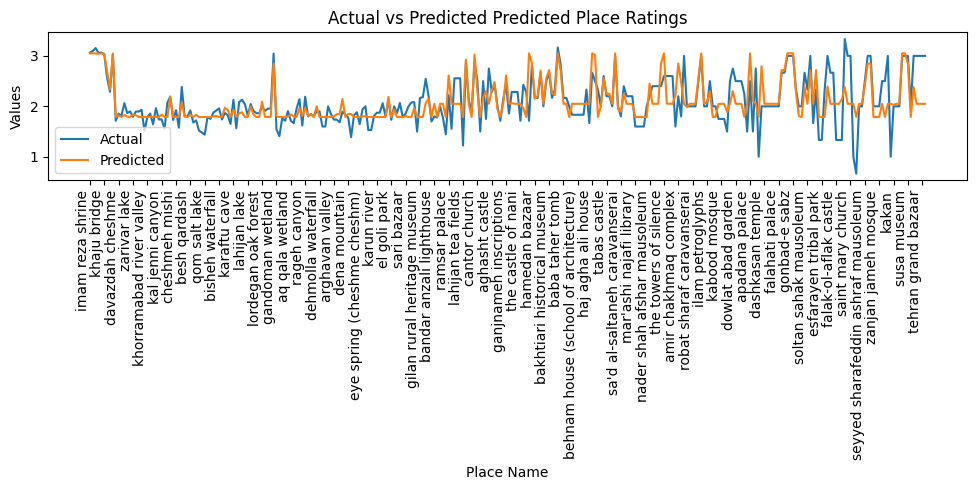

In [327]:
# Adjust the figure size to make it bigger and improve readability
plt.figure(figsize=(10, 5))  # Adjust the width and height

# Plot the actual and predicted values
plt.plot(merged_stats['Place_name'], merged_stats['Actual'], label='Actual')
plt.plot(merged_stats['Place_name'], merged_stats['Predicted'], label='Predicted')

# Set labels and title
plt.xlabel('Place Name')
plt.ylabel('Values')
plt.title('Actual vs Predicted Predicted Place Ratings')

# Limit the number of x-axis labels shown to avoid clutter
plt.xticks(ticks=range(0, len(merged_stats['Place_name']), 5), rotation=90, ha='right')

# Display the legend
plt.legend()

# Adjust layout to avoid overlap
plt.tight_layout()

# Show plot
plt.show()

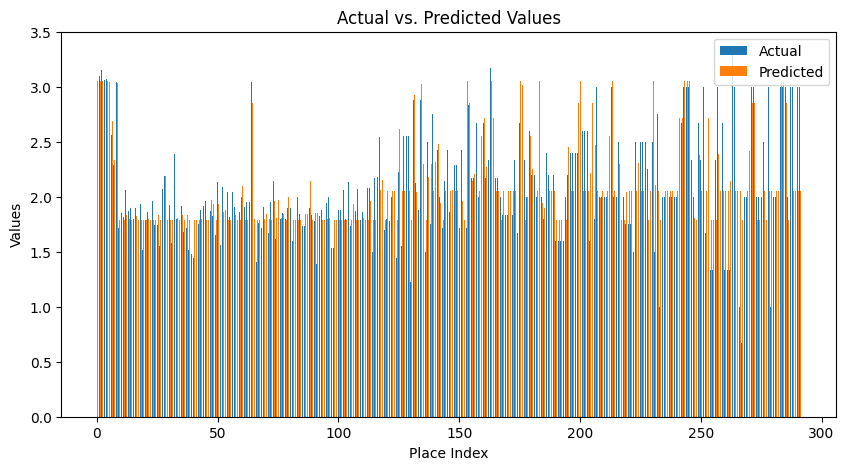

In [328]:
plt.figure(figsize=(10, 5))  # Adjust the width and height
indices = np.arange(len(merged_stats))
width = 0.35
plt.bar(indices, merged_stats['Actual'], width=width, label='Actual')
plt.bar(indices + width, merged_stats['Predicted'], width=width, label='Predicted')
plt.xlabel('Place Index')
plt.ylabel('Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

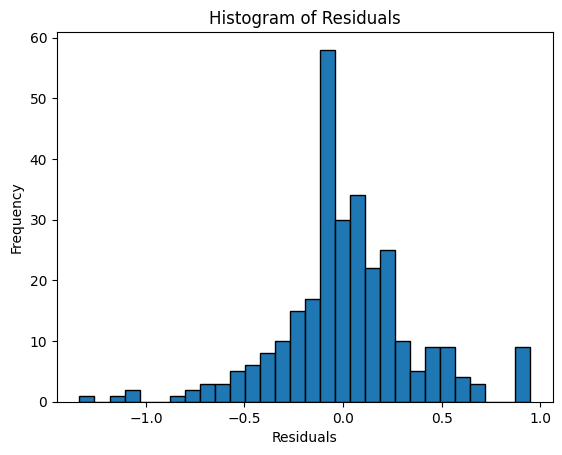

In [329]:
residuals = merged_stats['Actual'] - merged_stats['Predicted']
plt.hist(residuals, bins=30, edgecolor='k')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

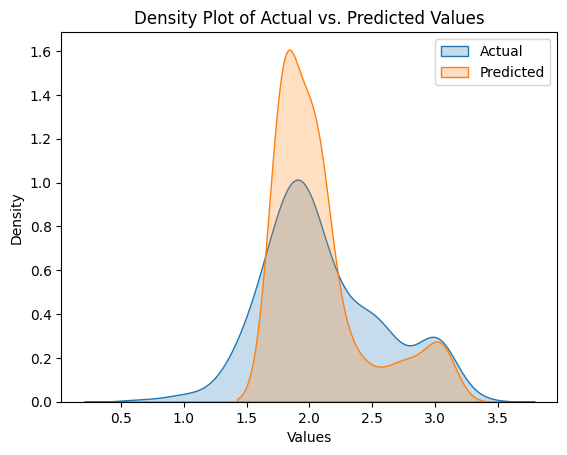

In [330]:
sns.kdeplot(merged_stats['Actual'], shade=True, label='Actual')
sns.kdeplot(merged_stats['Predicted'], shade=True, label='Predicted')
plt.xlabel('Values')
plt.title('Density Plot of Actual vs. Predicted Values')
plt.legend()
plt.show()

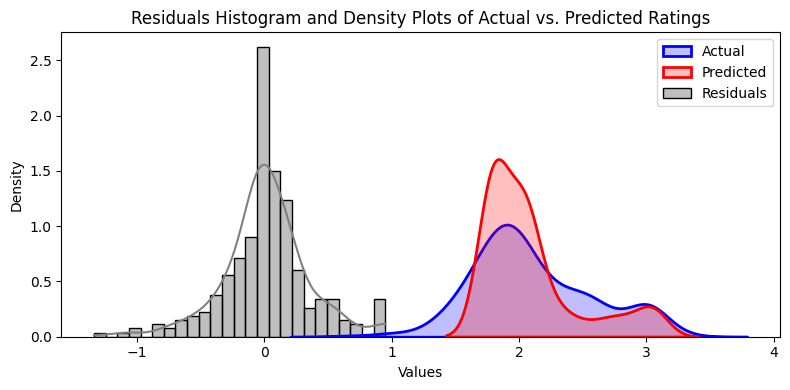

In [335]:
# Calculate residuals
residuals = merged_stats['Actual'] - merged_stats['Predicted']

# Create a figure
plt.figure(figsize=(8, 4))

# Plot histogram of residuals with density
sns.histplot(residuals, bins=25, color='gray', label='Residuals', kde=True, stat='density', alpha=0.5)

# Plot KDE plots of Actual and Predicted values
sns.kdeplot(merged_stats['Actual'], shade=True, label='Actual', color='blue', linewidth=2)
sns.kdeplot(merged_stats['Predicted'], shade=True, label='Predicted', color='red', linewidth=2)

# Customize the plot
plt.xlabel('Values')
plt.ylabel('Density')
plt.title('Residuals Histogram and Density Plots of Actual vs. Predicted Ratings')
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()

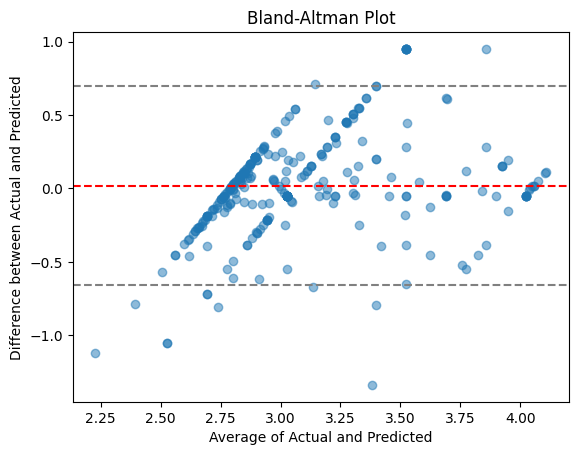

In [321]:
avg = (merged_stats['Actual'] + merged_stats['Predicted']) / 2
diff = merged_stats['Actual'] - merged_stats['Predicted']
plt.scatter(avg, diff, alpha=0.5)
plt.axhline(np.mean(diff), color='red', linestyle='--')
plt.axhline(np.mean(diff) + 1.96*np.std(diff), color='gray', linestyle='--')
plt.axhline(np.mean(diff) - 1.96*np.std(diff), color='gray', linestyle='--')
plt.xlabel('Average of Actual and Predicted')
plt.ylabel('Difference between Actual and Predicted')
plt.title('Bland-Altman Plot')
plt.show()

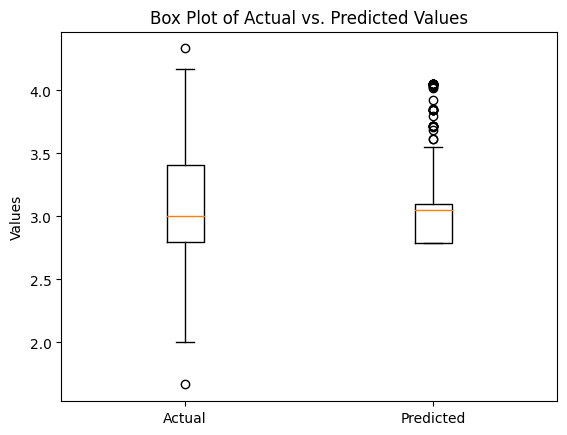

In [322]:
data_to_plot = [merged_stats['Actual'], merged_stats['Predicted']]
plt.boxplot(data_to_plot, labels=['Actual', 'Predicted'])
plt.ylabel('Values')
plt.title('Box Plot of Actual vs. Predicted Values')
plt.show()

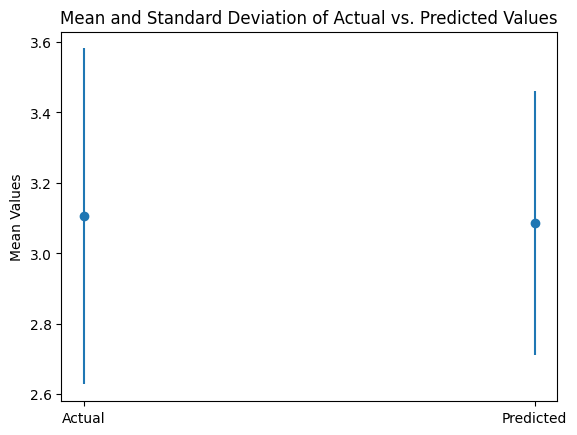

In [323]:
means = [merged_stats['Actual'].mean(), merged_stats['Predicted'].mean()]
stds = [merged_stats['Actual'].std(), merged_stats['Predicted'].std()]
plt.errorbar(['Actual', 'Predicted'], means, yerr=stds, fmt='o')
plt.ylabel('Mean Values')
plt.title('Mean and Standard Deviation of Actual vs. Predicted Values')
plt.show()

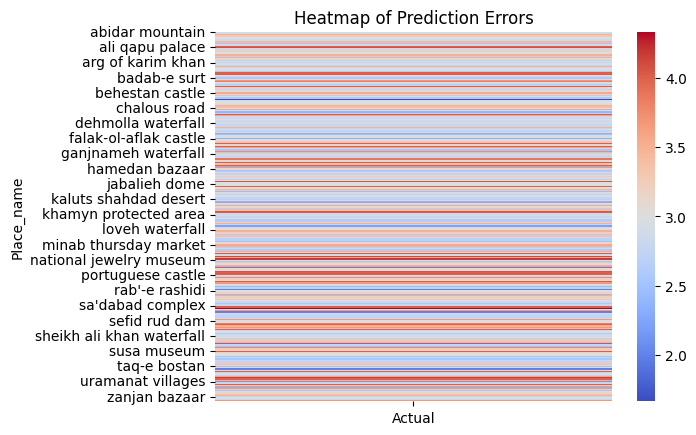

In [324]:
error_matrix = merged_stats.pivot_table(index='Place_name', values='Actual')
sns.heatmap(error_matrix, cmap='coolwarm')
plt.title('Heatmap of Prediction Errors')
plt.show()

In [325]:
# prompt: write me a code to see the top 10 place_id have the highest number of what_if other than 0

# Filter out rows where 'what_if' is 0
filtered_df = appended_df[appended_df['diff'] != 0]

# Group by 'Place_id' and count the occurrences
place_id_counts = filtered_df.groupby('Place_id')['diff'].count()

# Sort the counts in descending order
top_10_place_ids = place_id_counts.sort_values(ascending=False).head(40)

top_10_place_ids.index = top_10_place_ids.index+1

top_10_place_ids.index = top_10_place_ids.index.map(place_id_to_name)

print(top_10_place_ids)


Place_id
vakil bazaar                         30
chehel sotoun palace                 27
tomb of hafez                        17
naqsh-e jahan square                 11
nayband national park                11
imam reza shrine                     11
badab-e surt                         11
qom salt lake                        10
museum of contemporary art (arak)    10
alangdareh forest park                9
tagh-e gara                           9
meighan wetland                       9
taleghan valley                       9
poshtkuh protected area               8
shorabil lake                         8
hamun lake                            8
nojian waterfall                      8
tang-e tizab                          8
ali sadr cave                         8
minab thursday market                 8
choghakhor wetland                    8
besh qardash                          7
pasargadae                            7
alborz zipline                        7
hasanabad mountain             